# Segmenting and Clustering Neighborhoods
Start by collecting the data. Here is a snapshot from wikipedia.

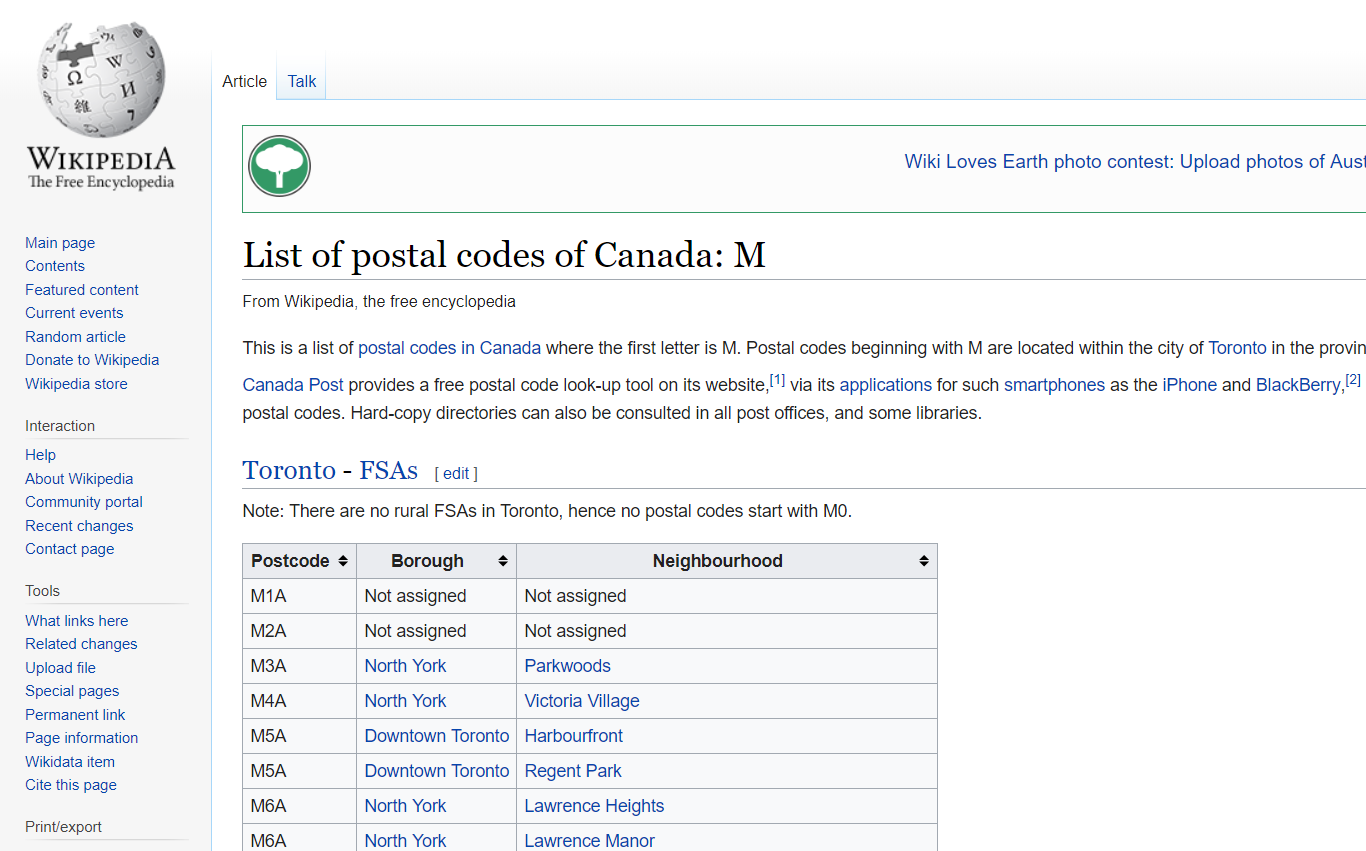

In [1]:
from IPython.display import Image
Image("postal_codes_canada_wikipedia.png")

In [2]:
import requests
import lxml.html as lh
import pandas as pd

url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

In [3]:
page = requests.get(url)
doc = lh.fromstring(page.content)

In [4]:
tr_elements = doc.xpath('//tr')

In [5]:
type(tr_elements), len(tr_elements)

(list, 294)

In [6]:
print(tr_elements[0].text_content())
print(tr_elements[1].text_content())


Postcode
Borough
Neighbourhood


M1A
Not assigned
Not assigned



In [7]:
data = []
for tr in tr_elements:
    tr_content = tr.text_content().split("\n")
    row = [item for item in tr_content if str(item).strip() != ""]
    if len(row) == 3:
        data.append(row)


Transfer this data to a data frame and do an initial clean.

In [8]:
df = pd.DataFrame(data)
df.columns = df.loc[0].values.tolist()
df.drop(df.index[0], inplace=True)
df = df[df["Borough"] != "Not assigned"]
df.reset_index(inplace=True, drop=True)
df.head(3)

,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront


In [9]:
df[df["Neighbourhood"] == "Not assigned"]  # we'll have to adjust for this a bit later...

,Postcode,Borough,Neighbourhood
6,M7A,Queen's Park,Not assigned


More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. These two rows will be combined into one row with the neighborhoods separated with a comma as shown in row 11 in the above table.

In [39]:
pd.options.mode.chained_assignment = None  # default='warn'

postcodes = df["Postcode"].unique()
neighbourhoods = []
boroughs = []
for postcode in postcodes:
    boro = df[df["Postcode"] == postcode]["Borough"].unique().tolist()
    if len(boro) != 1:
        raise ValueError("There should only be one Borough")
    boroughs.append(boro[0])
    
    hood = df[df["Postcode"] == postcode]["Neighbourhood"].unique().tolist()
    neighbourhoods.append(", ".join(hood))

dft = pd.DataFrame({"Postcode": postcodes, "Borough": boroughs, "Neighbourhood": neighbourhoods})

# If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough. 
# specifially, this turns up for M7A, Queen's Park above
borough_tocopy = dft.loc[dft["Neighbourhood"]=="Not assigned"]["Borough"].values.tolist()
print(borough_tocopy)
dft.loc[dft["Neighbourhood"]=="Not assigned", "Neighbourhood"] = borough_tocopy

# rename the postal code column
dft.rename(columns={'Postcode':'PostCode'}, inplace=True)
dft

["Queen's Park"]


,PostCode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Harbourfront, Regent Park"
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,M7A,Queen's Park,Queen's Park
5,M9A,Etobicoke,Islington Avenue
6,M1B,Scarborough,"Rouge, Malvern"
7,M3B,North York,Don Mills North
8,M4B,East York,"Woodbine Gardens, Parkview Hill"
9,M5B,Downtown Toronto,"Ryerson, Garden District"


We can do a quick check based on the M5A neighbourhood.

In [40]:
dft[dft["PostCode"] == "M5A"]

,PostCode,Borough,Neighbourhood
2,M5A,Downtown Toronto,"Harbourfront, Regent Park"


In [41]:
dft[dft["PostCode"] == "M7A"]  # and also that the neighbourhood adjustment for M7A has gone through

,PostCode,Borough,Neighbourhood
4,M7A,Queen's Park,Queen's Park


In [42]:
dft.shape  # we have 103 rows, 3 columns

(103, 3)

## The [geocoder](https://geocoder.readthedocs.io/index.html) example

In [34]:
import geocoder

In [35]:
# initialize your variable to None
postal_code = "M5G"
lat_lng_coords = None

# loop until you get the coordinates
counter = 0
while(lat_lng_coords is None):
    counter += 1
    g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
    lat_lng_coords = g.latlng
    print("Attempt %d, lat_lng_coords = %s" % (counter, str(lat_lng_coords)))
    if counter >= 10:
        break


Attempt 1, lat_lng_coords = None
Attempt 2, lat_lng_coords = None
Attempt 3, lat_lng_coords = None
Attempt 4, lat_lng_coords = None
Attempt 5, lat_lng_coords = None
Attempt 6, lat_lng_coords = None
Attempt 7, lat_lng_coords = None
Attempt 8, lat_lng_coords = None
Attempt 9, lat_lng_coords = None
Attempt 10, lat_lng_coords = None


So the example they gave us is highly unreliable... we'll have to read from csv instead.

In [52]:
df_coords = pd.read_csv("Geospatial_Coordinates.csv")
df_coords.rename(columns={'Postal Code':'PostCode'}, inplace=True)
df_coords.set_index("PostCode", inplace=True)
df_coords.head(3)

,Latitude,Longitude
PostCode,,
M1B,43.806686,-79.194353
M1C,43.784535,-79.160497
M1E,43.763573,-79.188711


In [53]:
lat = []
lng = []
for pc in dft["PostCode"].values:
    lat.append(df_coords.at[pc, "Latitude"])
    lng.append(df_coords.at[pc, "Longitude"])

In [54]:
dft["Latitude"] = lat
dft["Longitude"] = lng

dft

,PostCode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,M7A,Queen's Park,Queen's Park,43.662301,-79.389494
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242
6,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
7,M3B,North York,Don Mills North,43.745906,-79.352188
8,M4B,East York,"Woodbine Gardens, Parkview Hill",43.706397,-79.309937
9,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937


Run some checks...

In [56]:
dft[dft["PostCode"] == "M5G"]

,PostCode,Borough,Neighbourhood,Latitude,Longitude
24,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383


In [57]:
dft[dft["PostCode"] == "M5A"]

,PostCode,Borough,Neighbourhood,Latitude,Longitude
2,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.65426,-79.360636


## Explore and cluster the neighborhoods
First we'll start basic and create a map with the neighbourhoods on top.

Get the libs we need...

In [60]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


Get the latitude and longitude for Toronto.

In [65]:
# https://www.latlong.net/place/toronto-on-canada-27230.html
tlat = 43.651070
tlng = -79.347015

In [67]:
dft.columns

Index(['PostCode', 'Borough', 'Neighbourhood', 'Latitude', 'Longitude'], dtype='object')

In [69]:
map_toronto = folium.Map(location=[tlat, tlng], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(dft['Latitude'], dft['Longitude'], dft['Borough'], dft['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  

map_toronto